In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ursse.phase_space_trajectory as pst
# import ursse_cpp.sync_motion_sim as sm
from config_ursse import get_from_config, get_path_from_config, save_to_config
from ursse.path_assistant import PathAssistant
import os
import valstore as vt
images_dir = os.path.join(get_path_from_config("URSSE_sync_motion_note_dir"),
                          "images")
shift = PathAssistant('shift_05_26_2021')
np_rand_seed = 1
from ursse.data_processing import \
    get_event_delays, plot_arrival_time_hist, get_events_array, get_fanos, \
    plot_fanos_hist, process_file, read_event_delays, save_event_delays

iota_period_sec = get_from_config("IOTA_revolution_period")
dt_sec = get_from_config("dt")
iota_period_au = iota_period_sec/dt_sec

In [2]:
file_name = '1el_000.ptu'
df, n_revolutions = read_event_delays(shift.get_time_stamp_file_path(file_name))
t_delays = df.delay

/opt/homebrew/Caskroom/miniforge/base/envs/env/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


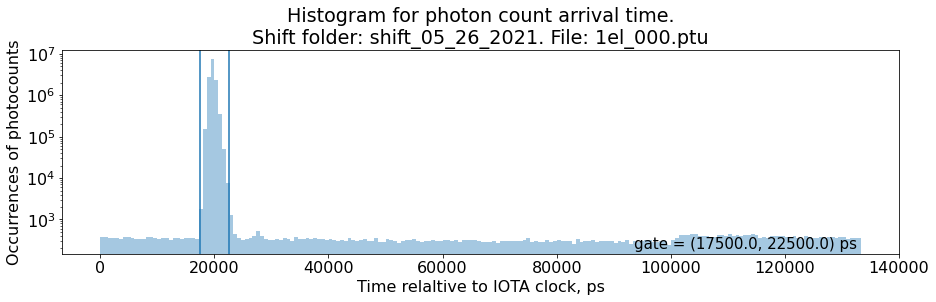

In [3]:
gate = (17500,22500)
plot_arrival_time_hist(t_delays, gate, bins=200, shift_folder_name=shift.shift_folder_name,
    time_stamp_file_name=file_name)

In [4]:
meas_df = pst.get_revolution_delay_df_one_gate(
    'shift_05_26_2021', '1el_000.ptu', gate=gate)

In [5]:
meas_df

,revolution,delay
0,284,0.431913
1,402,-0.252087
2,928,-0.237087
3,1015,-0.087087
4,1035,-0.405087
...,...,...
13051521,2250498629,0.473913
13051522,2250498838,0.106913
13051523,2250498875,-0.420087
13051524,2250498977,-0.106087


In [6]:
df0 = meas_df.iloc[10000:, :]
rev0 = df0.iloc[0,0]
t0=25000
first_fit_nper = 8
df0_first_fit = df0[df0['revolution']<t0*first_fit_nper+rev0]
from scipy.optimize import curve_fit
def f(t, a0, A, B, T):
    return a0 + A*np.cos(2*np.pi/T*t)+B*np.sin(2*np.pi/T*t)
x = df0_first_fit['revolution'].values
y = df0_first_fit['delay'].values
p0 = (np.mean(y), np.std(y), np.std(y), t0)
popt, pcov = curve_fit(f, x, y, p0=p0)
a0, a, b, T0 = popt
perr = np.sqrt(np.diag(pcov))
x_fit = np.linspace(x[0],x[-1],10000)
#x_fit_sec = x_fit*iota_period_sec
y_fit = f(x_fit, a0, a, b, T0)
y_fit_ = f(x, a0, a, b, T0)
T0, np.sqrt(np.mean((y_fit_-y)**2))

(25262.04320671665, 0.32357951551843495)

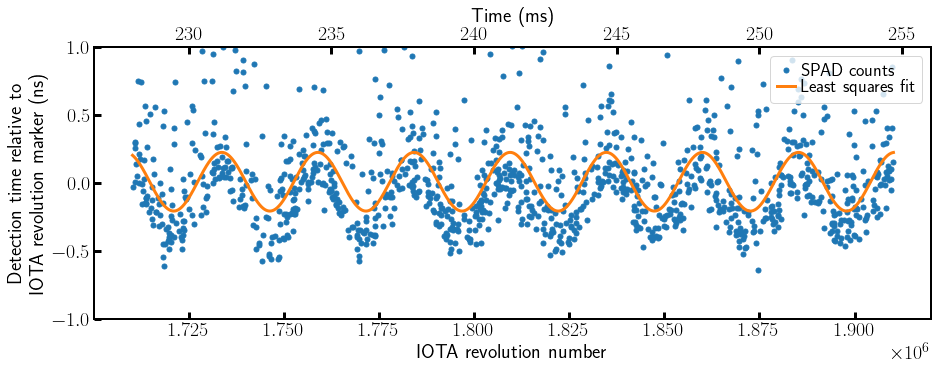

In [7]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
# plt.rcParams.update({'font.size': 15,
#                      'legend.fontsize':22,
#                      'errorbar.capsize': 3,
#                      'figure.figsize':(15,3)})
fig, ax = plt.subplots(figsize=(15,5))
# ax.errorbar(x, y, label='SPAD counts', yerr=0.4, marker='o', linestyle='None')
ax.plot(x, y, label='SPAD counts', marker='.', linestyle='None')
ax.plot(x_fit, y_fit, label='Least squares fit')
ax.set_ylabel('Detection time relative to\n IOTA revolution marker (ns)') #, fontsize=16)
ax.set_xlabel('IOTA revolution number')
ax1 = ax.twiny()
ax1.set_xlim(1000*iota_period_sec*np.asarray(ax.get_xlim()))
ax1.set_xlabel('Time (ms)')
ax.set_ylim(-1,1)
ax.legend(loc=1)#, fontsize=12)
plt.show()

In [39]:
dt0 = T0/10
meas_df['index_of_dt0_bin'] = (meas_df['revolution']/dt0).astype(int)
grouped_mean = meas_df.groupby('index_of_dt0_bin').mean()

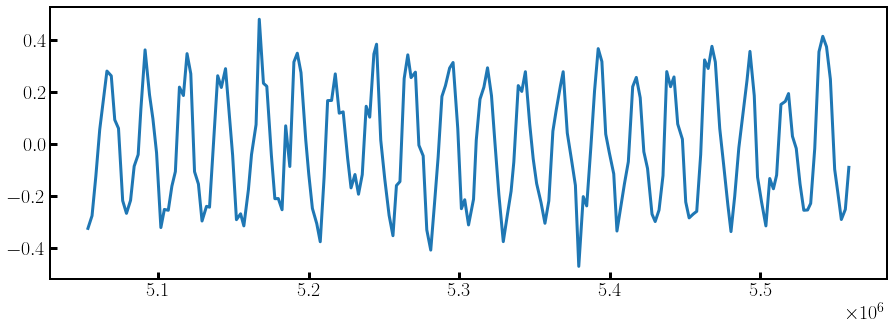

In [40]:
n0 = 2000
nplot = 200
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(grouped_mean.loc[n0:n0+nplot,'revolution'], grouped_mean.loc[n0:n0+nplot,'delay'])
plt.show()

In [7]:
meas_T0 = pst.get_initial_sync_period_estimate(meas_df)
# meas_phase_df, meas_fits_df = pst.get_phase_df_from_revoluton_delay_df(meas_df, meas_T0)
dt = 0.1
meas_sz_df = pst.get_sz_df(meas_df, spad_tts_ns=0, dt=dt)
# meas_polar_df = pst.get_polar_df(meas_phase_df, meas_sz_df)

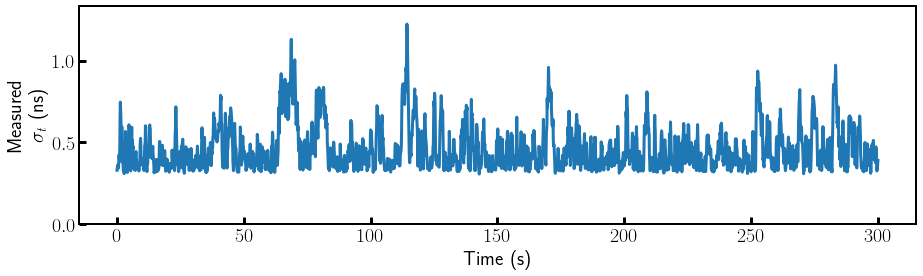

In [9]:
from ursse.path_assistant import get_plot_style_sheet
plt.style.use(get_plot_style_sheet("jinst"))
fig, ax = plt.subplots(figsize=(15,4))
ax.plot(meas_sz_df['time_sec'], meas_sz_df['sz_ns'])
ax.set_ylim(0,1.05*ax.get_ylim()[1])
ax.set_ylabel("Measured\n $\sigma_t$ (ns)")
ax.set_xlabel("Time (s)")
plt.show()

In [40]:
25e3*133e-9

0.0033250000000000003

In [41]:
meas_df

,revolution,delay,index_of_dt_bin,time_sec
0,284,0.431913,0,0.05
1,402,-0.252087,0,0.05
2,928,-0.237087,0,0.05
3,1015,-0.087087,0,0.05
4,1035,-0.405087,0,0.05
...,...,...,...,...
13051521,2250498629,0.473913,3000,300.05
13051522,2250498838,0.106913,3000,300.05
13051523,2250498875,-0.420087,3000,300.05
13051524,2250498977,-0.106087,3000,300.05
